# Importing libraries and loading data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import xgboost as xgb
import time

In [3]:
X_train = pd.read_csv('X_train.csv').values
X_test = pd.read_csv('X_test.csv').values
y_train = pd.read_csv('y_train.csv').values
y_test = pd.read_csv('y_test.csv').values

In [4]:
print('X_train shape:', X_train.shape, '\nX_test shape:', X_test.shape)
print('\ny_train shape:', y_train.shape, '\ny_test shape:', y_test.shape)

X_train shape: (34189, 57) 
X_test shape: (14653, 57)

y_train shape: (34189, 1) 
y_test shape: (14653, 1)


In [5]:
# Reshaping y sets for models, they need to be 1d arrays
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print('y_train shape:', y_train.shape, '\ny_test shape:', y_test.shape)

y_train shape: (34189,) 
y_test shape: (14653,)


In [6]:
round((np.sum(y_train == 1) *100) / len(y_train),2)

23.82

In [7]:
round((np.sum(y_train == 0) *100) / len(y_train),2)

76.18

We'll build 3 different models and tune hyperparameters using Random Search and cross validation. We'll use AUC as metric to compare performance between the models.

Logistic Regression

Random Forest

XGB

# Logistic Regression

In [9]:
param_lr = {
            'penalty':['elasticnet'],
            'C':[.001, .01, .1, 1, 10],
            'solver':['saga'],
            'l1_ratio':[0, 0.25, 0.5, 0.75, 1],
            'max_iter':[1200]
            }

In [10]:
lr = LogisticRegression()

In [11]:
lr_clf = RandomizedSearchCV(lr, param_distributions=param_lr, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=10)


In [12]:
start = time.time()
lr_model = lr_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 136 seconds


In [13]:
print(lr_model.best_params_)
print(lr_model.best_score_)

{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1200, 'l1_ratio': 0.5, 'C': 10}
0.9088500507911252


# Logistic Regression - Tuned model

In [14]:
lr_tuned = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.75,\
                              max_iter=1200, C=10, random_state=42)
lr_tuned.fit(X_train, y_train)

LogisticRegression(C=10, l1_ratio=0.75, max_iter=1200, penalty='elasticnet',
                   random_state=42, solver='saga')

In [15]:
y_pred_lr = lr_tuned.predict(X_train)
y_pred_proba_lr = lr_tuned.predict_proba(X_train)[:,1]

In [16]:
print(classification_report(y_train, y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     26046
           1       0.74      0.60      0.66      8143

    accuracy                           0.85     34189
   macro avg       0.81      0.77      0.78     34189
weighted avg       0.85      0.85      0.85     34189



In [17]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, y_pred_proba_lr)

In [18]:
auc_lr = auc(fpr_lr, tpr_lr)
auc_lr

0.9100329856898624

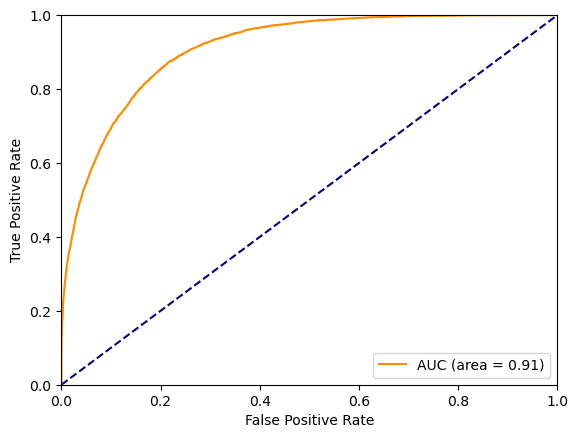

In [20]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, color="darkorange",
    label="AUC (area = %0.2f)" % auc_lr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [21]:
# Running grid search first for min_samples_leaf and split to get an idea of the range
param_rf = {'min_samples_leaf': [5, 10, 25, 50],
           'min_samples_split': [5, 10, 25, 50]}

In [22]:
rf = RandomForestClassifier(random_state=42)
rf_clf = GridSearchCV(rf, param_grid = param_rf, cv = 5, scoring = 'roc_auc', n_jobs = -1, \
                            verbose=10)

In [23]:
start = time.time()
rf_model = rf_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training time: 52 seconds


In [24]:
print(rf_model.best_params_)
print(rf_model.best_score_)

{'min_samples_leaf': 5, 'min_samples_split': 25}
0.914240055125482


Running a second round of tuning including more parameters, this time using Random Search


In [25]:
param_rf = {'n_estimators':[100, 300, 700, 1200],
            'max_depth':[2, 5, 10, 30],
            'max_features':[0.1, .4, .6, 1],
            'min_samples_split': [3, 5, 9],
            'min_samples_leaf': [3, 5, 9] }

In [26]:
rf_clf = RandomizedSearchCV(rf, param_distributions = param_rf, cv = 5, scoring = 'roc_auc', n_jobs = -1, \
                              verbose=10, random_state=42)


In [27]:
start = time.time()
rf_model = rf_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 166 seconds


In [28]:
print(rf_model.best_params_)
print(rf_model.best_score_)

{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 0.4, 'max_depth': 30}
0.91395116604475


# Random Forest - Tuned model

In [29]:
rf_tuned = RandomForestClassifier(n_estimators=700, min_samples_split = 5, min_samples_leaf = 9,\
                                  max_features= 0.4, max_depth=30)
rf_tuned.fit(X_train, y_train)


RandomForestClassifier(max_depth=30, max_features=0.4, min_samples_leaf=9,
                       min_samples_split=5, n_estimators=700)

In [30]:
y_pred_rf = rf_tuned.predict(X_train)
y_pred_proba_rf = rf_tuned.predict_proba(X_train)[:,1]

# Random Forest - Features importances

In [31]:
# Reading X_train again, but this time as a dataframe to get columns
X_cols = pd.read_csv('X_train.csv')


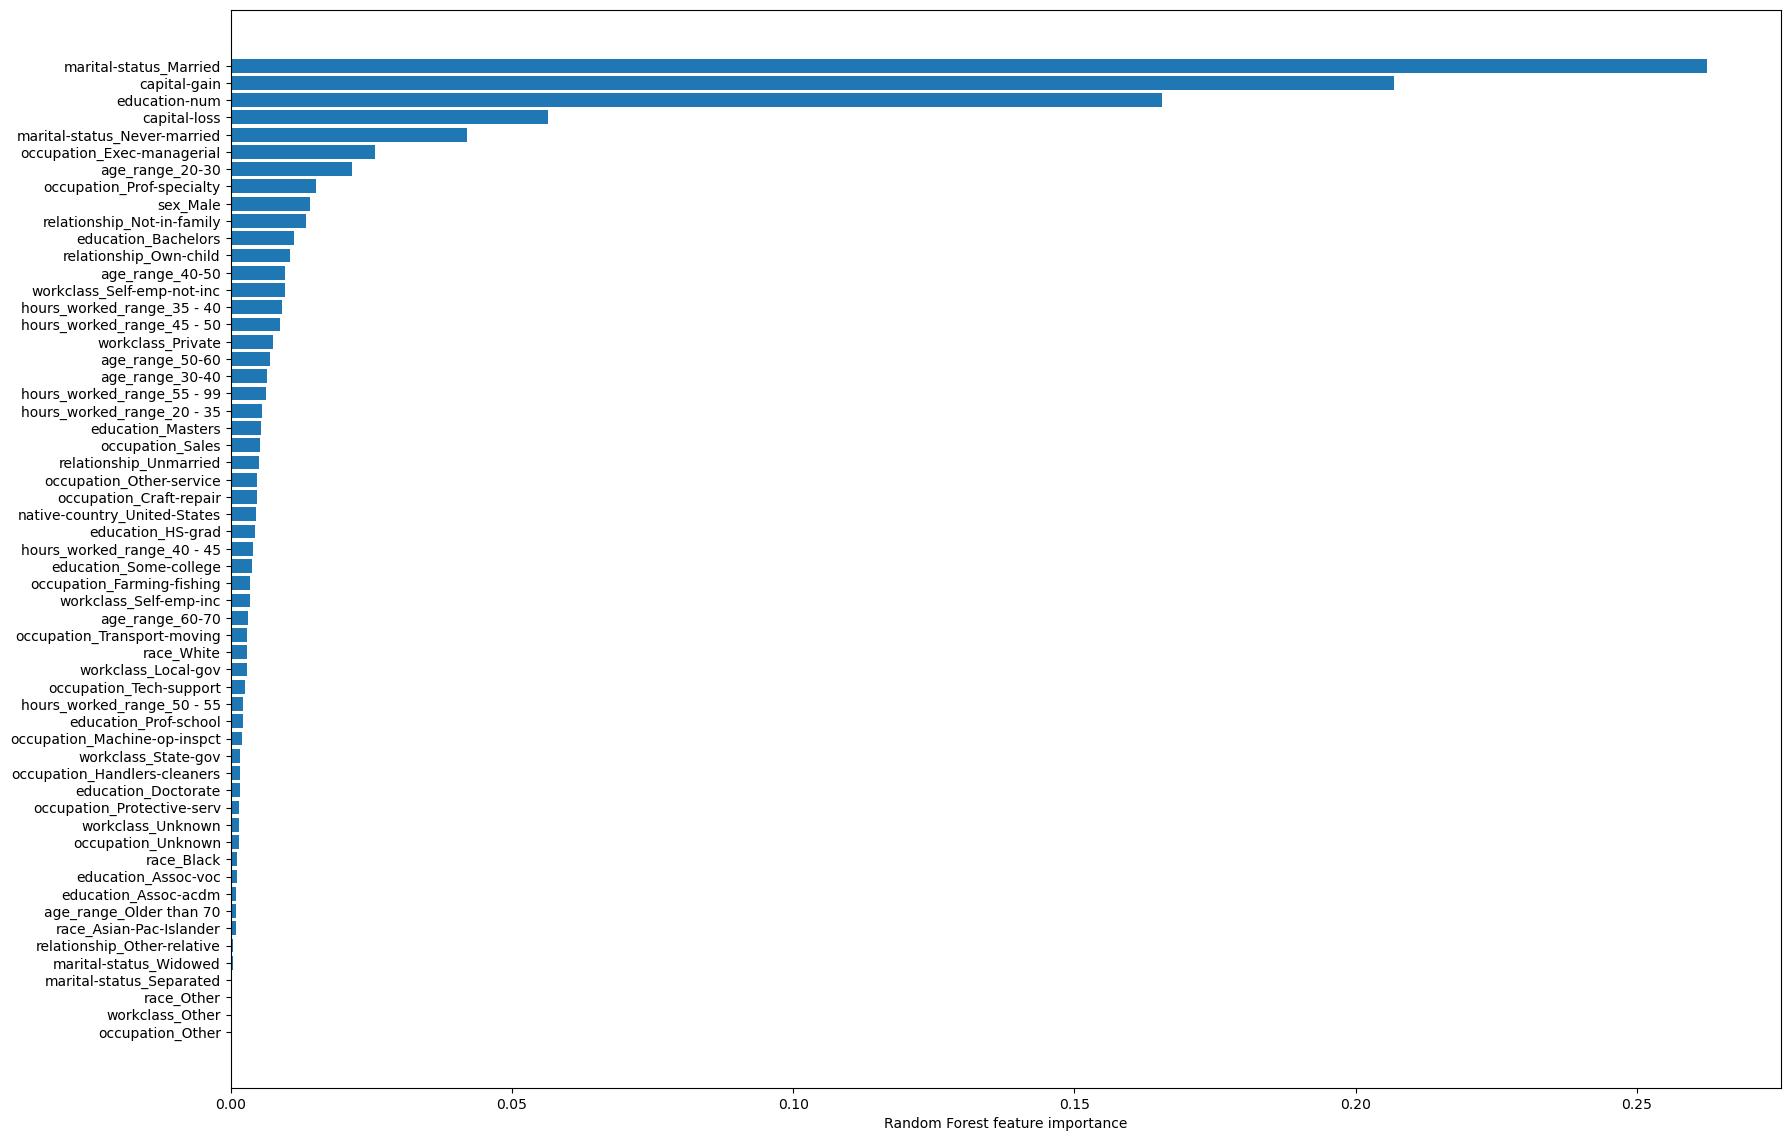

In [32]:
plt.figure(figsize=(20,14))
sorted_idx = rf_tuned.feature_importances_.argsort()
plt.barh(X_cols.columns[sorted_idx], rf_tuned.feature_importances_[sorted_idx])
plt.xlabel('Random Forest feature importance');


In [33]:
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     26046
           1       0.82      0.63      0.71      8143

    accuracy                           0.88     34189
   macro avg       0.85      0.79      0.82     34189
weighted avg       0.87      0.88      0.87     34189



In [34]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_pred_proba_rf)


In [35]:
auc_rf = auc(fpr_rf, tpr_rf)
auc_rf

0.9373496299337735

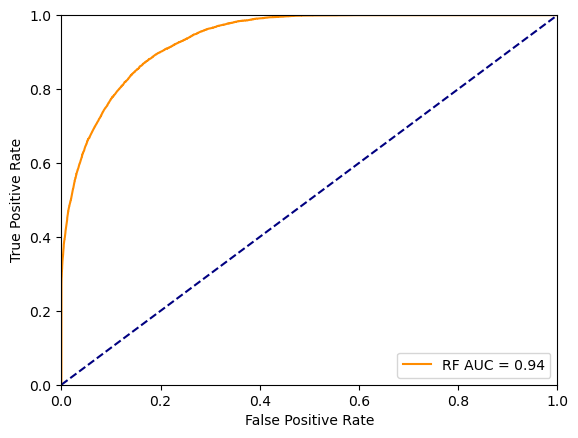

In [36]:
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange",
    label="RF AUC = %0.2f" % auc_rf)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# XGBoost

In [37]:
params_xg = {
            'n_estimators':[50, 100, 150],
            'booster':['gbtree','dart'],
            'colsample_bytree': [0.1, .4, .6, 1],    #subsample ratio of columns when constructing each tree
            'max_depth': [2, 5, 10, 20],
            'eta': [0.2, 0.3, 0.4]   #learning rate
            }

In [38]:
xg = xgb.XGBClassifier(objective='binary:logistic')

In [39]:
xg_clf = RandomizedSearchCV(xg, param_distributions=params_xg, scoring='roc_auc',\
                                   n_jobs=-1, cv=5, random_state=42)

In [40]:
start = time.time()
xg_model = xg_clf.fit(X_train, y_train)
end = time.time()
print('Training time:', round(end - start,), 'seconds')

Training time: 619 seconds


In [41]:
print(xg_model.best_params_)
print(xg_model.best_score_)

{'n_estimators': 150, 'max_depth': 5, 'eta': 0.2, 'colsample_bytree': 0.6, 'booster': 'gbtree'}
0.9275044156992989


# XGBoost - Tuned model

In [42]:
xg_tuned = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, booster='gbtree', eval_metric='auc',\
                           colsample_bytree=0.6, max_depth=5, eta=0.2, random_state=42, scale_pos_weight=3.2)
xg_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [43]:
y_pred_xg = xg_tuned.predict(X_train)
y_pred_proba_xg = xg_tuned.predict_proba(X_train)[:,1]

# XGBoost - Features importances

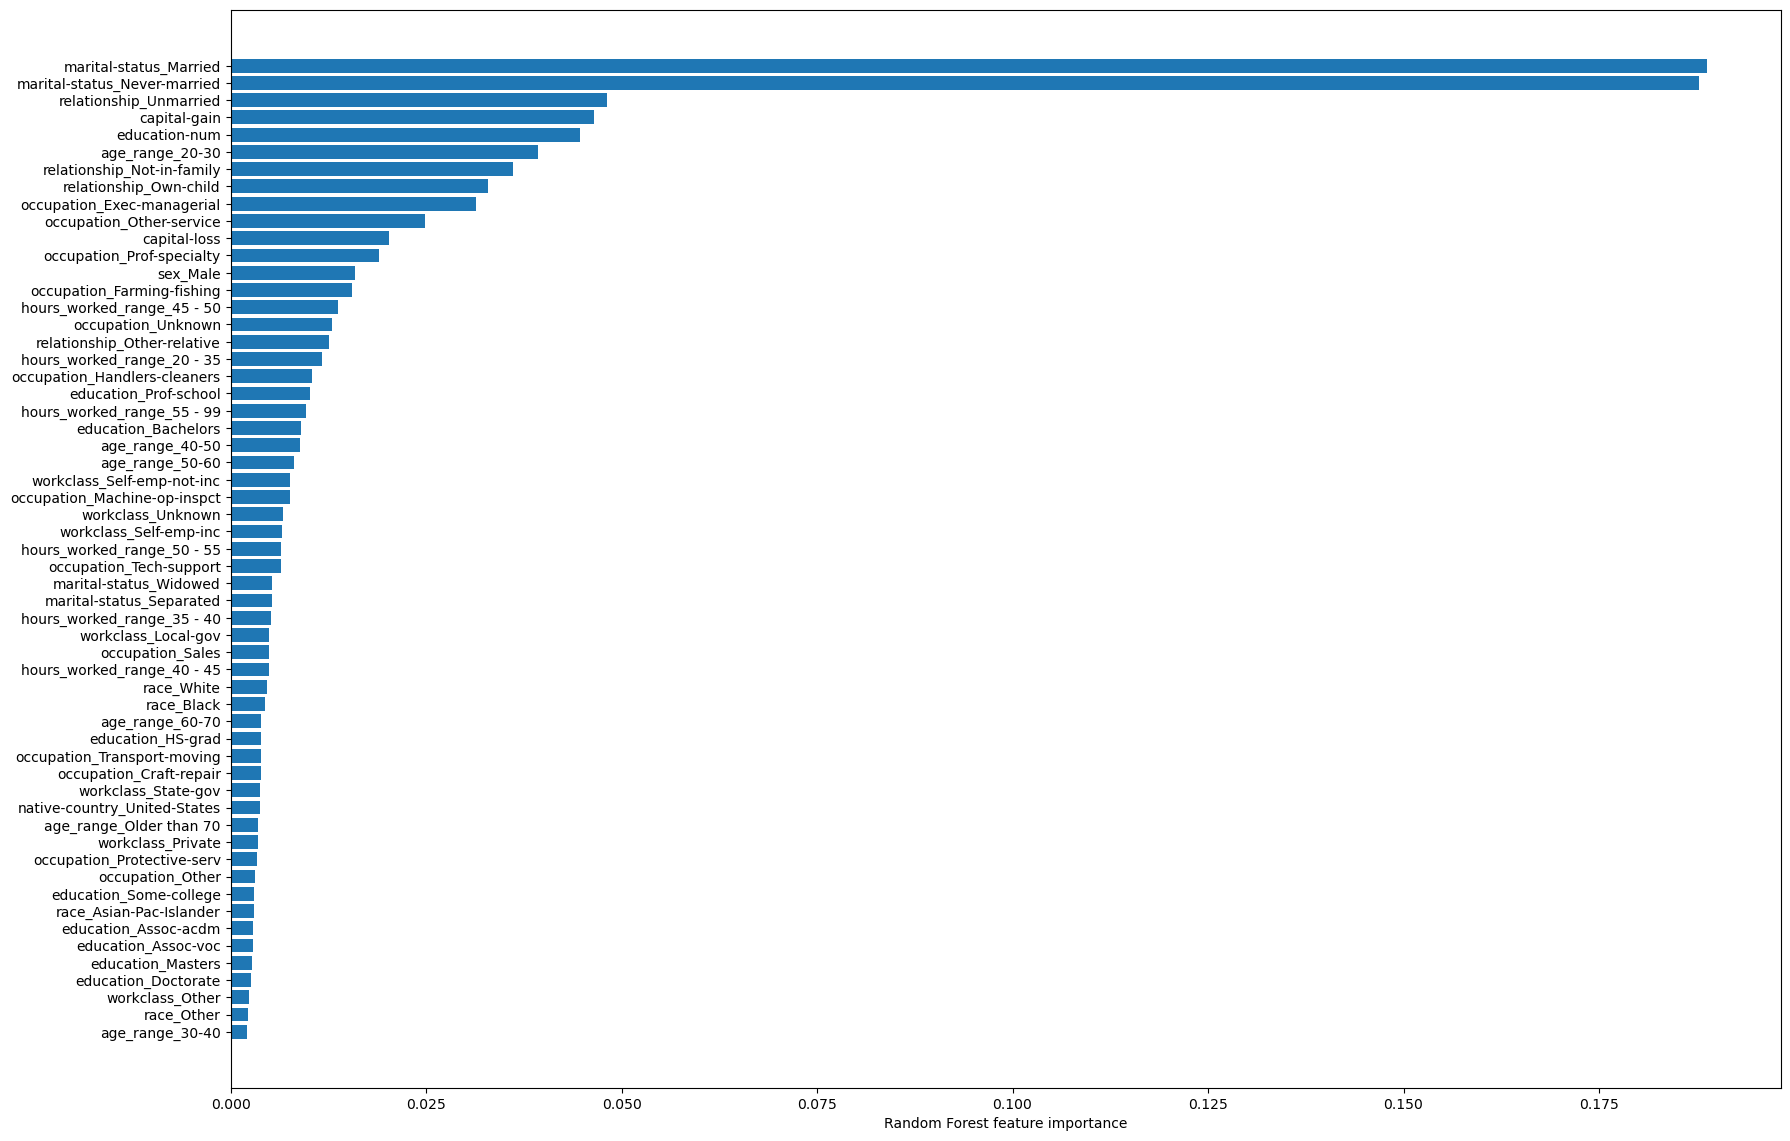

In [44]:
plt.figure(figsize=(20,14))
sorted_idx = xg_tuned.feature_importances_.argsort()
plt.barh(X_cols.columns[sorted_idx], xg_tuned.feature_importances_[sorted_idx])
plt.xlabel('Random Forest feature importance');

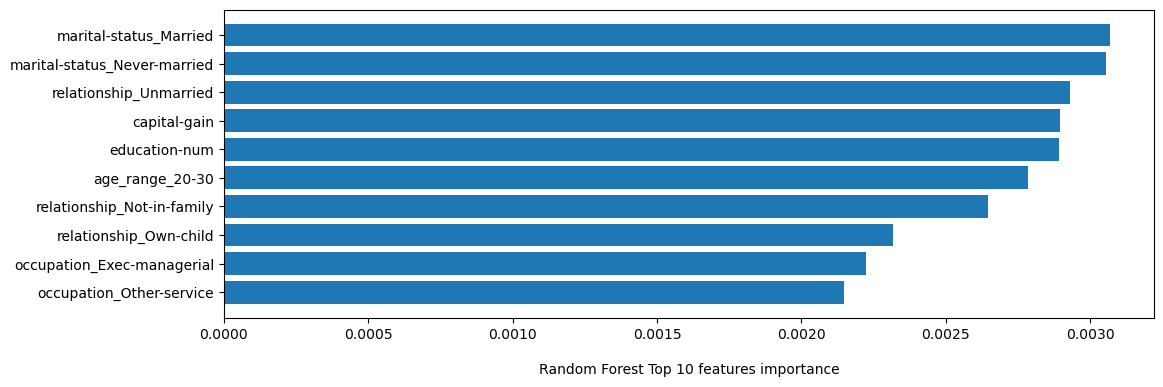

In [45]:
# Top 10 features
plt.figure(figsize=(12,4))
sorted_idx = xg_tuned.feature_importances_.argsort()
plt.barh(X_cols.columns[sorted_idx[-10:]], xg_tuned.feature_importances_[sorted_idx[:10]])
plt.xlabel('\nRandom Forest Top 10 features importance');

In [46]:
print(classification_report(y_train, y_pred_xg))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     26046
           1       0.62      0.90      0.73      8143

    accuracy                           0.84     34189
   macro avg       0.79      0.86      0.81     34189
weighted avg       0.88      0.84      0.85     34189



In [47]:
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_train, y_pred_proba_xg)
auc_xg = auc(fpr_xg, tpr_xg)
auc_xg

0.9431667288234857

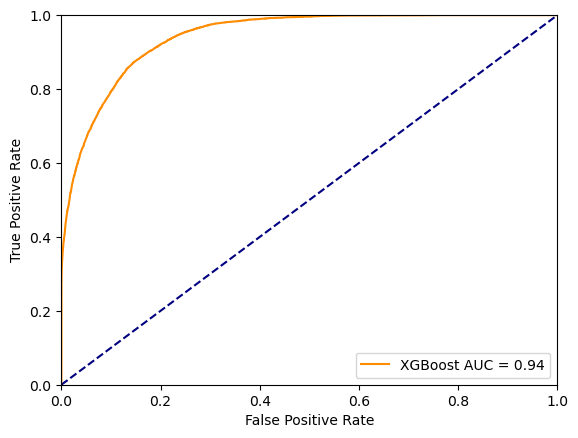

In [48]:
plt.figure()
plt.plot(fpr_xg, tpr_xg, color="darkorange",
    label="XGBoost AUC = %0.2f" % auc_xg)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Plotting the 3 models AUC

Based on the AUC best score, we'll choose the XGBoost model and adjust the threshold.


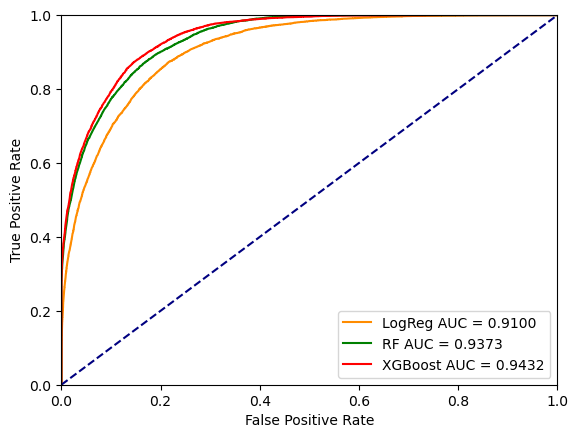

In [49]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, color="darkorange",
    label="LogReg AUC = %0.4f" % auc_lr)
plt.plot(fpr_rf, tpr_rf, color="green",
    label="RF AUC = %0.4f" % auc_rf)
plt.plot(fpr_xg, tpr_xg, color="red",
    label="XGBoost AUC = %0.4f" % auc_xg)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Default threshold

Let's print out the confusion matrix and classification report for our training set with default threshold of 0.5 as a base reference.


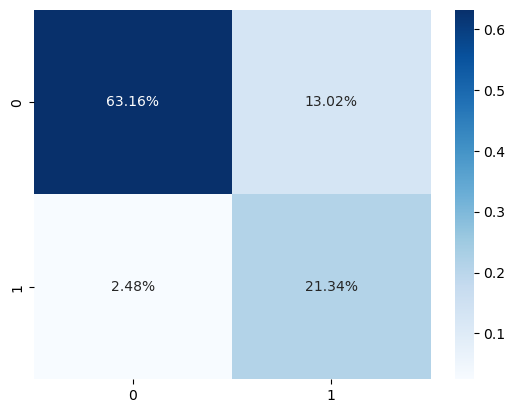

In [50]:
conf_matrix = confusion_matrix(y_train, y_pred_xg)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [51]:
print(classification_report(y_train, y_pred_xg))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     26046
           1       0.62      0.90      0.73      8143

    accuracy                           0.84     34189
   macro avg       0.79      0.86      0.81     34189
weighted avg       0.88      0.84      0.85     34189



# Threshold adjustment

Let's cycle thru different thresholds and capture precision, recall and F1 score


In [52]:
# Creating a dataframe to hold the values
df_thresholds = pd.DataFrame(columns=['Precision','Recall','F1 Score'])

for threshold in np.arange(0,1,0.01):
    y_temp = (y_pred_proba_xg > threshold).astype(int)
    df_thresholds.loc[threshold] = precision_score(y_train, y_temp), recall_score(y_train, y_temp),\
    f1_score(y_train, y_temp)


In [53]:
# Max F1 score for reference
df_thresholds[df_thresholds['F1 Score'] == df_thresholds['F1 Score'].max()]


,Precision,Recall,F1 Score
0.61,0.690875,0.824757,0.751903


Let's plot our precision, recall and F1 score for different thresholds.

For our business case we're more focused on class 1 (income >50k) since we'll target products or services more tailored to these customers. In this case we'll base our decision on Precision since we want to minimize our False Positives (Type I error).

We'll choose 0.8 as our threshold, this will give us a precision of 85%. Recall will be lower, but our priority for this case is a precision of at least 85%.

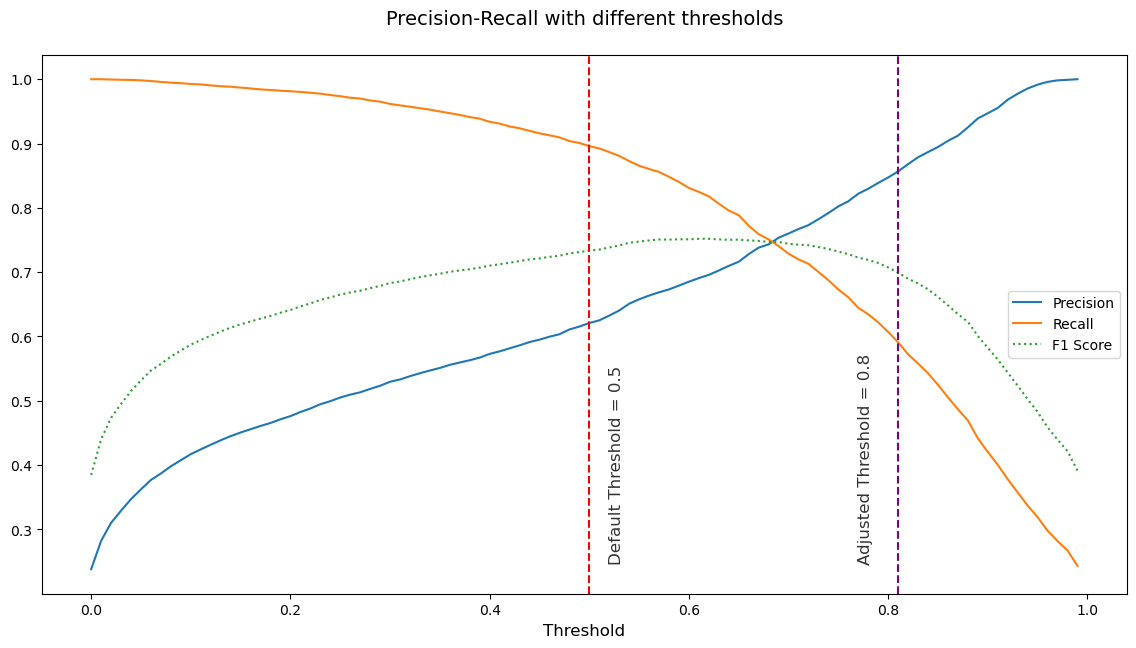

In [54]:
plt.figure(figsize=(14,7))
plt.plot(df_thresholds.index, df_thresholds['Precision'], label='Precision')
plt.plot(df_thresholds.index, df_thresholds['Recall'], label='Recall')
plt.plot(df_thresholds.index, df_thresholds['F1 Score'], ':', label='F1 Score')
plt.axvline(0.5, color='red', linestyle='--')
plt.text(.52,.25,'Default Threshold = 0.5',rotation=90, alpha=0.8, fontsize=12)
plt.axvline(0.81, color='purple', linestyle='--')
plt.text(.77,.25,'Adjusted Threshold = 0.8',rotation=90, alpha=0.8, fontsize=12)
plt.xlabel('Threshold', fontsize=12)
plt.title('Precision-Recall with different thresholds\n', fontsize=14)
plt.legend();

Setting the threshold to 0.8 for our train predictions and let'see how the confusion matrix and classification report look now.


In [55]:
y_threshold = (y_pred_proba_xg > 0.8).astype(int)

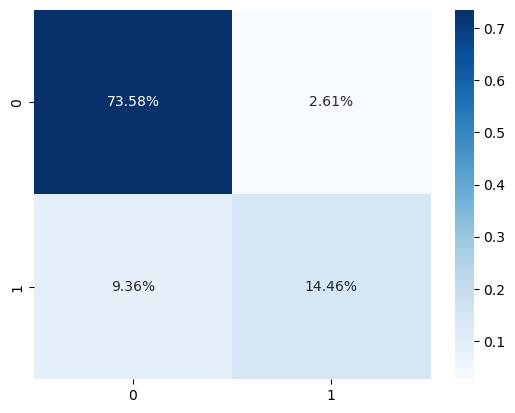

In [56]:
conf_matrix = confusion_matrix(y_train, y_threshold)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [59]:
print(classification_report(y_train, y_threshold))

              precision    recall  f1-score   support

           0       0.89      0.97      0.92     26046
           1       0.85      0.61      0.71      8143

    accuracy                           0.88     34189
   macro avg       0.87      0.79      0.82     34189
weighted avg       0.88      0.88      0.87     34189



We're getting 85% for precision and 61% for recall.


# Final validation on our test set

In [58]:
y_test_pred = xg_tuned.predict(X_test)
y_test_pred_proba = xg_tuned.predict_proba(X_test)[:,1]

In [60]:
y_test_threshold = (y_test_pred_proba > 0.8).astype(int)


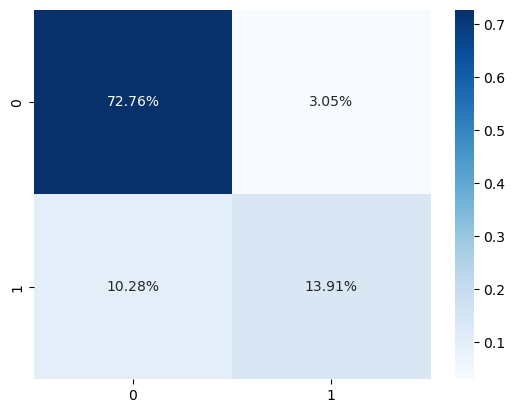

In [61]:
conf_matrix = confusion_matrix(y_test, y_test_threshold)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues');


In [62]:
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     11109
           1       0.82      0.58      0.68      3544

    accuracy                           0.87     14653
   macro avg       0.85      0.77      0.80     14653
weighted avg       0.86      0.87      0.86     14653



Precision for our test set went a bit lower (82%) than our training set (85%). Similar for recall, it dropped 4 points. Model doesn't look to be overfitted and it generalizes well.
